# Defect Predictor
## Objective
> To derive a model that will predict the number of bugs the project will produce while reaching the QA Stage

In [1]:
%matplotlib inline

import pickle
import pandas as pd

from IPython.display import HTML, display
import matplotlib

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
matplotlib.style.use('ggplot')

The original obtained dataset `./dataset/original_dataset.xls` is cleaned of unecessary features, converted to csv, and is stored as `./dataset/dataset.csv`.

In [2]:
# reading the dataset
dataset_csv = pd.read_csv('./dataset/dataset.csv')
dataset_csv.head(10)

,complexity,criticality,technology,no_of_requirements,BRD_Availability,FS_Availability,development_methodology,change_in_schedule,release_duration,documentation_quality,requirement_validation,environment,automation_scope,environment_downtime,unit_test_defects,build_quality,dependencies_criticality,type_of_requirement,no_of_test_scenerio,no_of_test_cases,no_of_defects
0,High,High,"Java 8 , Oracle 12g, Thick client",3,Yes,Yes,Waterfall,No,12,5,Yes,"Dev,SIT, UAT &Production",No,Yes,5,3,Medium,Non Functional,25,150,10
1,High,High,"Java 8 , Otracle 12g, Thick client",38,Yes,Yes,Waterfall,No,24,5,Yes,"Dev,SIT, UAT &Production",No,Yes,70,3,Medium,Functional,70,700,100
2,Medium,Medium,. NET,24,No,Yes,Hybrid Agile,No,8,4,Yes,"Integration, Regression, Production",No,Yes,0,3,Medium,Functional,0,167,12
3,Medium,Medium,. NET,15,No,Yes,Hybrid Agile,No,7,4,Yes,"Integration, Regression, Production.",No,Yes,0,3,Medium,Functional,0,130,6
4,Medium,High,EY Canvas,6,Yes,Yes,Iterative,Yes,4,5,Yes,"SIT, UAT, Production, Training",No,Yes,0,3,Medium,Functional,25,150,120
5,Medium,High,EY Canvas,6,Yes,Yes,Iterative,Yes,4,5,Yes,"SIT, UAT, Production, Training",No,Yes,0,3,Medium,Functional,28,180,200
6,High,High,SharePoint/SSIS Package,29,No,Yes,Hybrid Agile,Yes,4,5,Yes,SIT,No,Yes,30,3,High,Functional,350,750,255
7,High,High,SharePoint/SSIS Package,19,No,Yes,Hybrid Agile,Yes,4,5,Yes,SIT,No,Yes,30,3,High,Functional,250,550,235
8,Low,Medium,.NET,6,Yes,No,"Hybrid (Waterfall, Iterative)",No,13,4,Yes,SIT,Yes,No,0,3,Low,Functional,10,25,174
9,Medium,Low,.NET,3,Yes,No,Waterfall,No,2,5,Yes,"SIT, UAT",No,No,0,3,Medium,Functional,6,15,29


The dataset has features with binary values like `Yes` and `No` and rating values like `High`, `Medium` and `Low`. We first convert those values to numerical representation.

In [3]:
# `Low`, `Medium`, `High` to 1, 2, 3
dataset_csv['complexity'] = dataset_csv['complexity'].apply(lambda x: 1 if x == 'Low' else 2 if x == 'Medium' else 3)
dataset_csv['criticality'] = dataset_csv['criticality'].apply(lambda x: 1 if x == 'Low' else 2 if x == 'Medium' else 3)
dataset_csv['dependencies_criticality'] = dataset_csv['dependencies_criticality'].apply(lambda x: 1 if x == 'Low' else 2 if x == 'Medium' else 3)

# `Yes`, `No` to 1, 0
dataset_csv['BRD_Availability'] = dataset_csv['BRD_Availability'].apply(lambda x: 1 if x == 'Yes' else 0)
dataset_csv['FS_Availability'] = dataset_csv['FS_Availability'].apply(lambda x: 1 if x == 'Yes' else 0)
dataset_csv['change_in_schedule'] = dataset_csv['change_in_schedule'].apply(lambda x: 1 if x == 'Yes' else 0)
dataset_csv['requirement_validation'] = dataset_csv['requirement_validation'].apply(lambda x: 1 if x == 'Yes' else 0)
dataset_csv['automation_scope'] = dataset_csv['automation_scope'].apply(lambda x: 1 if x == 'Yes' else 0)
dataset_csv['environment_downtime'] = dataset_csv['environment_downtime'].apply(lambda x: 1 if x == 'Yes' else 0)

dataset_csv.head(10)

,complexity,criticality,technology,no_of_requirements,BRD_Availability,FS_Availability,development_methodology,change_in_schedule,release_duration,documentation_quality,requirement_validation,environment,automation_scope,environment_downtime,unit_test_defects,build_quality,dependencies_criticality,type_of_requirement,no_of_test_scenerio,no_of_test_cases,no_of_defects
0,3,3,"Java 8 , Oracle 12g, Thick client",3,1,1,Waterfall,0,12,5,1,"Dev,SIT, UAT &Production",0,1,5,3,2,Non Functional,25,150,10
1,3,3,"Java 8 , Otracle 12g, Thick client",38,1,1,Waterfall,0,24,5,1,"Dev,SIT, UAT &Production",0,1,70,3,2,Functional,70,700,100
2,2,2,. NET,24,0,1,Hybrid Agile,0,8,4,1,"Integration, Regression, Production",0,1,0,3,2,Functional,0,167,12
3,2,2,. NET,15,0,1,Hybrid Agile,0,7,4,1,"Integration, Regression, Production.",0,1,0,3,2,Functional,0,130,6
4,2,3,EY Canvas,6,1,1,Iterative,1,4,5,1,"SIT, UAT, Production, Training",0,1,0,3,2,Functional,25,150,120
5,2,3,EY Canvas,6,1,1,Iterative,1,4,5,1,"SIT, UAT, Production, Training",0,1,0,3,2,Functional,28,180,200
6,3,3,SharePoint/SSIS Package,29,0,1,Hybrid Agile,1,4,5,1,SIT,0,1,30,3,3,Functional,350,750,255
7,3,3,SharePoint/SSIS Package,19,0,1,Hybrid Agile,1,4,5,1,SIT,0,1,30,3,3,Functional,250,550,235
8,1,2,.NET,6,1,0,"Hybrid (Waterfall, Iterative)",0,13,4,1,SIT,1,0,0,3,1,Functional,10,25,174
9,2,1,.NET,3,1,0,Waterfall,0,2,5,1,"SIT, UAT",0,0,0,3,2,Functional,6,15,29


One-Hot encoding is applied to the remaining categorical fields since numerical assignments like above don't make any meaning.

In [4]:
# Applying one-hot encoding
dataset_csv = pd.get_dummies(dataset_csv)
dataset_csv.head(10)

,complexity,criticality,no_of_requirements,BRD_Availability,FS_Availability,change_in_schedule,release_duration,documentation_quality,requirement_validation,automation_scope,environment_downtime,unit_test_defects,build_quality,dependencies_criticality,no_of_test_scenerio,no_of_test_cases,no_of_defects,technology_. NET,technology_. Net and Archer,technology_.NET,technology_AEM 6.0,"technology_ASP.NET, SQL","technology_ASP.NET, SQL, SSRS, SSIS","technology_ASP.NET,SQL","technology_ASP.Net MVC5, EF6.1, Kendo UI, SQL Server 2012, SSRS, Window Services, Aspose Cell, Jquery",technology_EY Canvas,"technology_Eagle,Pace,star,Oracle","technology_Eagle,Pace,star,Oracle,TIBCO","technology_Eagle,Pace,star,Oracle,TIBCO,Informatica",technology_Informatica,"technology_JSF, EJB, Oracle, Hibernate, JBoss ESB","technology_Java 8 , Oracle 12g, Thick client","technology_Java 8 , Otracle 12g, Thick client","technology_Oracle,Eagle,star,pace","technology_Oracle,Sql","technology_Oracle,Unix,Pace,Star,eagle",technology_SharePoint/SSIS Package,development_methodology_Agile,"development_methodology_Hybrid (Waterfall, Iterative)",development_methodology_Hybrid Agile,development_methodology_Iterative,development_methodology_Waterfall,"environment_DEV,SIT,UAT","environment_Dev,SIT, UAT &Production","environment_Integration, Regression, Production","environment_Integration, Regression, Production.",environment_SIT,"environment_SIT, UAT","environment_SIT, UAT, Production","environment_SIT, UAT, Production, Training","environment_SIT, UAT, Training, Production",type_of_requirement_Functional,type_of_requirement_Non Functional
0,3,3,3,1,1,0,12,5,1,0,1,5,3,2,25,150,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,3,3,38,1,1,0,24,5,1,0,1,70,3,2,70,700,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,2,2,24,0,1,0,8,4,1,0,1,0,3,2,0,167,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
3,2,2,15,0,1,0,7,4,1,0,1,0,3,2,0,130,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2,3,6,1,1,1,4,5,1,0,1,0,3,2,25,150,120,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
5,2,3,6,1,1,1,4,5,1,0,1,0,3,2,28,180,200,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
6,3,3,29,0,1,1,4,5,1,0,1,30,3,3,350,750,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
7,3,3,19,0,1,1,4,5,1,0,1,30,3,3,250,550,235,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
8,1,2,6,1,0,0,13,4,1,1,0,0,3,1,10,25,174,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
9,2,1,3,1,0,0,2,5,1,0,0,0,3,2,6,15,29,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


The dataset is split into X and y, encapsulated as an object and dumped into `./dataset/dataset.pickle`

In [5]:
y = pd.DataFrame(dataset_csv['no_of_defects'])
y.head(10)

,no_of_defects
0,10
1,100
2,12
3,6
4,120
5,200
6,255
7,235
8,174
9,29


In [6]:
X = dataset_csv.drop('no_of_defects', 1)
X.head(10)

,complexity,criticality,no_of_requirements,BRD_Availability,FS_Availability,change_in_schedule,release_duration,documentation_quality,requirement_validation,automation_scope,environment_downtime,unit_test_defects,build_quality,dependencies_criticality,no_of_test_scenerio,no_of_test_cases,technology_. NET,technology_. Net and Archer,technology_.NET,technology_AEM 6.0,"technology_ASP.NET, SQL","technology_ASP.NET, SQL, SSRS, SSIS","technology_ASP.NET,SQL","technology_ASP.Net MVC5, EF6.1, Kendo UI, SQL Server 2012, SSRS, Window Services, Aspose Cell, Jquery",technology_EY Canvas,"technology_Eagle,Pace,star,Oracle","technology_Eagle,Pace,star,Oracle,TIBCO","technology_Eagle,Pace,star,Oracle,TIBCO,Informatica",technology_Informatica,"technology_JSF, EJB, Oracle, Hibernate, JBoss ESB","technology_Java 8 , Oracle 12g, Thick client","technology_Java 8 , Otracle 12g, Thick client","technology_Oracle,Eagle,star,pace","technology_Oracle,Sql","technology_Oracle,Unix,Pace,Star,eagle",technology_SharePoint/SSIS Package,development_methodology_Agile,"development_methodology_Hybrid (Waterfall, Iterative)",development_methodology_Hybrid Agile,development_methodology_Iterative,development_methodology_Waterfall,"environment_DEV,SIT,UAT","environment_Dev,SIT, UAT &Production","environment_Integration, Regression, Production","environment_Integration, Regression, Production.",environment_SIT,"environment_SIT, UAT","environment_SIT, UAT, Production","environment_SIT, UAT, Production, Training","environment_SIT, UAT, Training, Production",type_of_requirement_Functional,type_of_requirement_Non Functional
0,3,3,3,1,1,0,12,5,1,0,1,5,3,2,25,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,3,3,38,1,1,0,24,5,1,0,1,70,3,2,70,700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,2,2,24,0,1,0,8,4,1,0,1,0,3,2,0,167,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
3,2,2,15,0,1,0,7,4,1,0,1,0,3,2,0,130,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,2,3,6,1,1,1,4,5,1,0,1,0,3,2,25,150,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
5,2,3,6,1,1,1,4,5,1,0,1,0,3,2,28,180,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
6,3,3,29,0,1,1,4,5,1,0,1,30,3,3,350,750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
7,3,3,19,0,1,1,4,5,1,0,1,30,3,3,250,550,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
8,1,2,6,1,0,0,13,4,1,1,0,0,3,1,10,25,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
9,2,1,3,1,0,0,2,5,1,0,0,0,3,2,6,15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


In [7]:
# A class structure to hold the dataset. Object of this will be dumped using Pickle
class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

In [8]:
dataset = Dataset(X, y)
dataset.X.describe()

,complexity,criticality,no_of_requirements,BRD_Availability,FS_Availability,change_in_schedule,release_duration,documentation_quality,requirement_validation,automation_scope,environment_downtime,unit_test_defects,build_quality,dependencies_criticality,no_of_test_scenerio,no_of_test_cases,technology_. NET,technology_. Net and Archer,technology_.NET,technology_AEM 6.0,"technology_ASP.NET, SQL","technology_ASP.NET, SQL, SSRS, SSIS","technology_ASP.NET,SQL","technology_ASP.Net MVC5, EF6.1, Kendo UI, SQL Server 2012, SSRS, Window Services, Aspose Cell, Jquery",technology_EY Canvas,"technology_Eagle,Pace,star,Oracle","technology_Eagle,Pace,star,Oracle,TIBCO","technology_Eagle,Pace,star,Oracle,TIBCO,Informatica",technology_Informatica,"technology_JSF, EJB, Oracle, Hibernate, JBoss ESB","technology_Java 8 , Oracle 12g, Thick client","technology_Java 8 , Otracle 12g, Thick client","technology_Oracle,Eagle,star,pace","technology_Oracle,Sql","technology_Oracle,Unix,Pace,Star,eagle",technology_SharePoint/SSIS Package,development_methodology_Agile,"development_methodology_Hybrid (Waterfall, Iterative)",development_methodology_Hybrid Agile,development_methodology_Iterative,development_methodology_Waterfall,"environment_DEV,SIT,UAT","environment_Dev,SIT, UAT &Production","environment_Integration, Regression, Production","environment_Integration, Regression, Production.",environment_SIT,"environment_SIT, UAT","environment_SIT, UAT, Production","environment_SIT, UAT, Production, Training","environment_SIT, UAT, Training, Production",type_of_requirement_Functional,type_of_requirement_Non Functional
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,2.535714,2.625000,31.232143,0.589286,0.553571,0.232143,4.232143,4.803571,0.785714,0.196429,0.750000,14.071429,2.946429,2.410714,43.714286,146.178571,0.035714,0.017857,0.035714,0.196429,0.035714,0.035714,0.035714,0.035714,0.035714,0.017857,0.017857,0.089286,0.017857,0.142857,0.017857,0.017857,0.142857,0.017857,0.017857,0.035714,0.196429,0.017857,0.071429,0.446429,0.267857,0.017857,0.035714,0.017857,0.017857,0.714286,0.017857,0.107143,0.035714,0.035714,0.892857,0.107143
std,0.659595,0.619751,43.499213,0.496416,0.501621,0.426021,4.164748,0.772708,0.414039,0.400892,0.436931,28.871412,0.296626,0.733033,64.227356,202.896042,0.187256,0.133631,0.187256,0.400892,0.187256,0.187256,0.187256,0.187256,0.187256,0.133631,0.133631,0.287736,0.133631,0.353094,0.133631,0.133631,0.353094,0.133631,0.133631,0.187256,0.400892,0.133631,0.259870,0.501621,0.446850,0.133631,0.187256,0.133631,0.133631,0.455842,0.133631,0.312094,0.187256,0.187256,0.312094,0.312094
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,5.750000,0.000000,0.000000,0.000000,2.000000,5.000000,1.000000,0.000000,0.750000,0.000000,3.000000,2.000000,5.750000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [9]:
# Dumping the dataset object
with open('./dataset/dataset.pickle', 'wb') as saveFile:
    pickle.dump(dataset, saveFile)

The dataset is next split into train and test set. 30% of the dataset is taken for testing and the remaining is using for training.

In [10]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.3)

The dataset is next normalized to have 0 mean and unit variance. This is done so that all features can be treated equally.

In [11]:
Scaler = StandardScaler().fit(X_train)

X_train = Scaler.transform(X_train)

The dataset is used to train AdaBoostRegressor, RandomForestRegressor, and GradientBoostingRegressor. The performance is compared later.

In [12]:
%time

# AdaBoostRegressor
param_grid_AdaBoostRegressor = {
        'learning_rate': [2, 1, 0.5, 0.01],
        'loss': ['linear', 'square', 'exponential']
    }

regr1 = GridSearchCV(AdaBoostRegressor(), param_grid_AdaBoostRegressor)
regr1.fit(X_train, y_train.values.ravel())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [2, 1, 0.5, 0.01], 'loss': ['linear', 'square', 'exponential']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
%time

# RandomForestRegressor
regr2 = RandomForestRegressor()
regr2.fit(X_train, y_train.values.ravel())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [14]:
%time

# GradientBoostingRegressor
regr3 = GradientBoostingRegressor()
regr3.fit(X_train, y_train.values.ravel())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

The test dataset is scaled using the Standard Scaler to predict the efficiency

In [15]:
# Scaling the test set
X_test = Scaler.transform(X_test)

The r-squared value for each regressor is computed on both training and test data

In [16]:
# Computing r-squared values
table = """
<table>
<tr>
<th> Regressor </th>
<th> train set </th>
<th> test set </th>
</tr>
<tr>
<th> AdaBoost Regressor </th>
<td> {} </td>
<td> {} </td>
</tr>
<tr>
<th> RandomForest Regressor </th>
<td> {} </td>
<td> {} </td>
</tr>
<tr>
<th> GradientBoosting Regressor </th>
<td> {} </td>
<td> {} </td>
</tr>
</table>
"""

train_score_1 = regr1.score(X_train, y_train)
test_score_1  = regr1.score(X_test, y_test)

train_score_2 = regr2.score(X_train, y_train)
test_score_2  = regr2.score(X_test, y_test)

train_score_3 = regr3.score(X_train, y_train)
test_score_3  = regr3.score(X_test, y_test)

display(HTML(table.format(train_score_1, test_score_1, train_score_2, test_score_2, train_score_3, test_score_3)))

Regressor,train set,test set
AdaBoost Regressor,0.947636030880867,0.6652128748946979
RandomForest Regressor,0.9459133497643231,0.4834173192735966
GradientBoosting Regressor,0.9996728236652319,0.7492273902101149


One of our Regressor gives us a r-squared value of `0.7492273902101149`. Hence, using this classifer, we can predict the number of defects that may occur  while reaching the QA Stage. We can further make improvements manually making assumptions about the information. 

Making assumptions, we found out that `no_of_test_scenerio` is co-related with `no_of_defects`. A bubble chart with `no_of_test_scenerio` in X-axis and `no_of_defects` in Y-axis in plotted below.

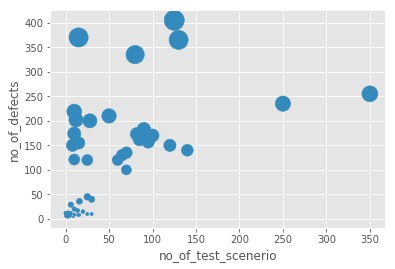

In [17]:
dataset_csv.plot.scatter(x='no_of_test_scenerio', y='no_of_defects', s=dataset_csv['no_of_defects'])

From the above plot, we could see that the most number of defects occur when the number of test scenerio are less than 150. Hence, we can reduce the number of defects increasing the number of test scenerios and futhermore, the above regressor to predict the number of defects that may occur while reaching the QA Stage.

In [18]:
# Dumping the regressors
with open('./regressors/AdaBoostRegressor.pickle', 'wb') as f1, open('./regressors/RandomForestRegressor.pickle', 'wb') as f2, open('./regressors/GradientBoostingRegressor.pickle', 'wb') as f3:
    pickle.dump(regr1, f1)
    pickle.dump(regr2, f2)
    pickle.dump(regr3, f3)